# Simulating lightcurves for SNe Ia

In [2]:
# Please enter the filename of the ztf_sim output fiel you would like to use
survey_file = '/home/ufeindt/data/ZTF/one_year_sim_incomplete.db'

# Please enter the path to where you have placed the Schlegel, Finkbeiner & Davis (1998) dust map files
# You can also set the environment variable SFD_DIR to this path (in that case the variable below should be None)
sfd98_dir = '/home/ufeindt/data/sfd98'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import simsurvey as simul

In [4]:
ccd_corners = np.genfromtxt('data/ZTF_corners.txt')
ccds = [ccd_corners[4*k+16:4*k+20] for k in range(16)]

In [9]:
# Load simulated survey from file (download from ftp://ftp.astro.caltech.edu/users/ebellm/one_year_sim_incomplete.db)
# Currently DES filters are used as proxies for ZTF filters
plan = simul.SurveyPlan(load_opsim=survey_file, band_dict={'g': 'desg', 'r': 'desr'}, ccds=ccds)

mjd_range = (plan.cadence['time'].min(), plan.cadence['time'].max())

In [19]:
tr = simul.get_sn_generator([0.,0.01], ratekind="basic", 
                            dec_range=[-30,90],
                            mjd_range=[mjd_range[0] - 60, mjd_range[-1] + 24],
                            sfd98_dir=sfd98_dir)

In [20]:
tr.ntransient

9

In [22]:
instprop = {"desg":{"gain":1.,"zp":30,"zpsys":'ab'},
            "desr":{"gain":1.,"zp":30,"zpsys":'ab'}}

survey = simul.SimulSurvey(generator=tr, plan=plan, instprop=instprop)

In [23]:
survey.obs_fields

IndexError: list index out of range

In [16]:
survey.obs_ccds

[array([], dtype=float64), array([[9]]), array([[14]]), array([[ 8],
        [15]]), array([[11]])]

In [11]:
lcs = survey.get_lightcurves(
    # This cell may give an error because of the progress bar widget.
    # Just delete the following line to fix this.
    progress_bar=True, notebook=True
)

Determining field IDs for all objects

Generating lightcurves



IndexError: index out of bounds

In [8]:
lcs[0]

time,band,flux,fluxerr,zp,zpsys,field
float64,str4,float64,float64,int64,str2,int64
57467.5179183,desr,12896.1384473,1711.5138634,30,ab,550
57467.5183812,desr,9114.17654403,1711.51456189,30,ab,550
57474.4968695,desg,72176.9545092,2076.60918444,30,ab,550
57474.4973324,desg,70869.753179,2076.61045184,30,ab,550
57474.5313128,desg,74326.5297526,1929.78344188,30,ab,550
57474.5317758,desg,78263.8771127,1929.78480318,30,ab,550
57487.4611707,desr,106083.128417,1336.11484352,30,ab,550
57487.4616337,desr,105221.847695,1336.11437121,30,ab,550
57487.4620966,desr,103945.227048,1336.1138989,30,ab,550


## Analysing the output

The output of `get_lightcurves()` is a `LightcurveCollection` object. Below are some examples how to assess survey statistics based on this.

The first skyplot shows all SNe that were active when a field was observed (but they may have been too faint to be detected). The second skyplot shows the SNe that had at least one $5\sigma$ detection. 

/home/ufeindt/.local/lib/python2.7/site-packages/astrobject-0.3.6-py2.7.egg/astrobject/utils/plot/skyplot.py:41: UserWarning: You are using matplotlib version < 1.5.0. The padding of the xlabel has been adjusted. You can use the option "xlabelpad" to adjust.
/usr/local/lib/python2.7/dist-packages/matplotlib/projections/geo.py:489: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


SNe pointed to: 27610 out of 33980


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


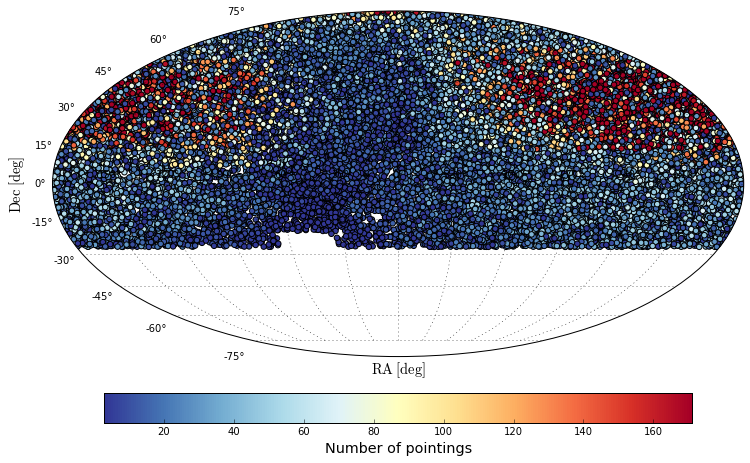

In [8]:
idx = lcs.meta['idx_orig']
n_obs = np.zeros(survey.generator.ntransient)
n_obs[idx] = np.array([len(a) for a in lcs])

survey.generator.show_skycoverage(cscale=n_obs, cblabel="Number of pointings", mask=idx)
print 'SNe pointed to: %i out of %i'%(np.sum(n_obs > 0), survey.generator.ntransient)

SNe detected: 17094 out of 33980


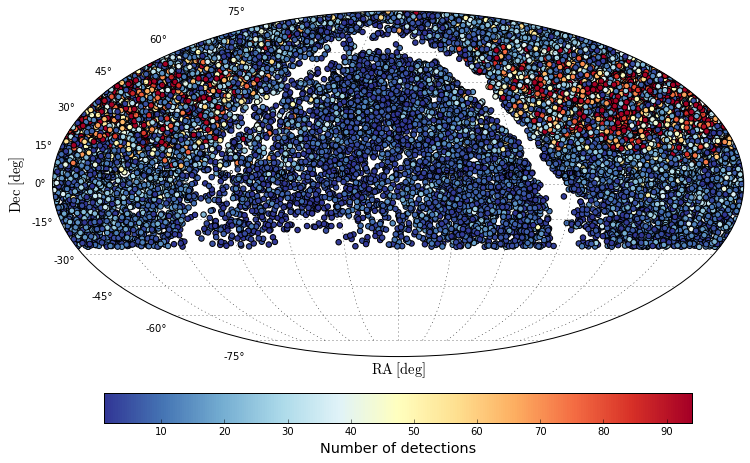

In [9]:
t_exp = -20

lcs_det = [lc[lc['flux']/lc['fluxerr'] > 5] for lc in lcs]
lcs_det = [lc[lc['time'] > t_exp*(1+lc.meta['z']) + lc.meta['t0']] for lc in lcs_det]

idx_det = lcs.meta['idx_orig'][np.array([len(lc) > 0 for lc in lcs_det])]
n_det = np.zeros(survey.generator.ntransient)
lcs_det = [lc for lc in lcs_det if len(lc) > 0]
n_det[idx_det] = np.array([len(a) for a in lcs_det])

survey.generator.show_skycoverage(cscale=n_det, cblabel="Number of detections", mask=idx_det)
print 'SNe detected: %i out of %i'%(np.sum(n_det > 0), survey.generator.ntransient)

In [10]:
z = np.array([lc.meta['z'] for lc in lcs_det])
p_i = np.array([lc['time'].min() - lc.meta['t0'] for lc in lcs_det])
p_e = np.array([lc['time'].max() - lc.meta['t0'] for lc in lcs_det])

The two last figures show how early the SNe are detected and at what redshift.

SNe found before peak: 12064


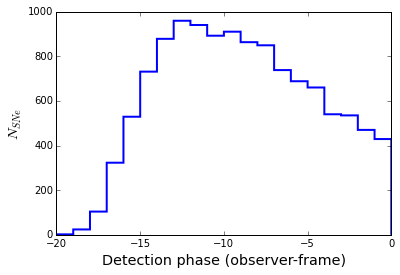

In [11]:
plt.hist(p_i, lw=2, histtype='step', range=(-20,0), bins=20)
print 'SNe found before peak:', np.sum(p_i < 0)
plt.xlabel('Detection phase (observer-frame)', fontsize='x-large')
plt.ylabel(r'$N_{SNe}$', fontsize='x-large')

SNe found 14 observer-frame days before peak: 1713
Local SNe (z < 0.1) found 14 observer-frame days before peak: 584


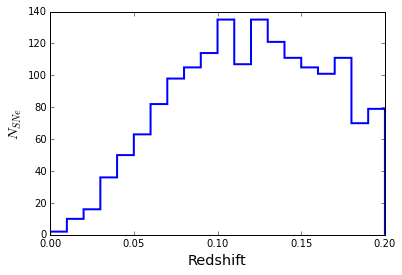

In [12]:
p_lim = -14
n = np.array([len(lc) for lc in lcs_det])
snr_max = np.array([max(lc['flux']/lc['fluxerr']) for lc in lcs_det])
plt.hist(z[(p_i < p_lim) & (snr_max >= 10)], lw=2, histtype='step', range=(0,0.2),bins=20)
print 'SNe found 14 observer-frame days before peak:', np.sum(p_i < p_lim) 
print 'Local SNe (z < 0.1) found 14 observer-frame days before peak:', np.sum((p_i < p_lim) & (z < 0.1))
plt.xlabel('Redshift', fontsize='x-large')
plt.ylabel(r'$N_{SNe}$', fontsize='x-large')
_ = plt.xlim((0, 0.2))